# Imports

In [50]:
import numpy as np
from tqdm import tqdm
import time
import random
import matplotlib.pyplot as plt

# Core algorithm

### Utility class

In [51]:
# useful class for time complexity evaluation

class counter:
    def __init__(self, name=''):
        self.c = 0
        self.breakpoint = time.time()
        self.total_time = 0
        self.name = name
    def start_breakpoint(self):
        self.breakpoint = time.time()
    def stop_breakpoint(self):
        self.total_time += (time.time() - self.breakpoint)
        self.c += 1
    def print_value(self):
        print(self.name, self.c, self.total_time, self.total_time/self.c)

### Common functions

In [52]:
"""
Cumulative probability
"""
def compute_cumul_proba(proba_i):
    return np.concatenate(([0], np.cumsum(proba_i)))

"""
Finds which interval a threshold belongs to
"""
def finder(type_space_i, threshold_i):
    return np.searchsorted(type_space_i, threshold_i, side='left', sorter=None)

def finder_opti(type_space_i, threshold_i):
    # optimization: frequent case
    if type_space_i[0] > threshold_i:
        return 0
    # optimization: frequent case
    if type_space_i[-1] < threshold_i:
        return len(type_space_i)
    return finder(type_space_i, threshold_i)

"""
Computes mu for DGPD
"""
def mu(y, p, s):
  return (p - s)/(p - s + y - s)

"""
Computes lambda for DGPD
"""
def lam(t, r, y, s):
  return (t - r)/(t - r + y - s)

"""
Computes alpha and beta for DGPD
"""
def search_space_boundaries(t, r, y, p, s):
  m = mu(y, p, s)
  l = lam(t, r, y, s)
  return min(m, l), max(m, l)

"""
Returns the utility of agent i on local game j given (action_1, action_2)
"""
def utility(U, i, j, action_1, action_2):
    return U[i-1][j-1][0 if action_1 == 'C' else 1][0 if action_2 == 'C' else 1]

"""
Returns delta of agent i on local game j given opponent action 'action'
"""
def delta(U, i, j, action):
    if i == 1:
        return utility(U, i, j, 'C', action) - utility(U, i, j, 'D', action)
    if i == 2:
        return utility(U, i, j, action, 'C') - utility(U, i, j, action, 'D')

"""
Returns Delta_i of agent i
"""
def Delta(U, i):
    return delta(U, i, 1, 'D')*delta(U, i, 2, 'C') - delta(U, i, 1, 'C')*delta(U, i, 2, 'D')

"""
Returns the threshold function of agent i for a given payoff matrix
"""
def generate_threshold_func(U, i):

    delta_i1C = delta(U, i, 1, 'C')
    delta_i1D = delta(U, i, 1, 'D')
    
    delta_i2C = delta(U, i, 2, 'C')
    delta_i2D = delta(U, i, 2, 'D')

    def threshold_function(zeta_i_C):

        a = delta_i1D + zeta_i_C*(delta_i1C - delta_i1D)
        b = delta_i2D + zeta_i_C*(delta_i2C - delta_i2D)

        threshold = a/(a - b)
        strategy_type = 'C/D' if a > b else 'D/C'

        return threshold, strategy_type
    
    return threshold_function

"""
Returns the threshold function of agent i for a given payoffs of DGPD
"""
def generate_threshold_func_dgpd(t, r, y, p, s):
  a = t - r - p + s
  b = p - s
  c = b + y - s
  return lambda zeta: (zeta*a + b)/(zeta*a + c) 

"""
Compute mutual best responses between agent 1 and 2
"""  
def compute_mutual_responses(zeta_2_C, cumul_proba_2, type_space_2, threshold_functions):

    # compute agent 2 best response
    threshold_2, strategy_type_2 = threshold_functions[1](zeta_2_C)
    
    k = finder_opti(type_space_2, threshold_2)   
    zeta_1_C = cumul_proba_2[k]    
    
    if strategy_type_2 == 'D/C': 
        zeta_1_C = 1 - zeta_1_C

    # compute agent 1 best response given agent 2 best response
    threshold_1, strategy_type_1 = threshold_functions[0](zeta_1_C)

    return threshold_1, strategy_type_1, threshold_2, strategy_type_2

"""
Returns whether the threshold belongs to i-th interval of type_space
"""
def in_type_interval(type_space, threshold, i):
    if i == 0:
        return type_space[i] >= threshold
    elif i == len(type_space):
        return type_space[i-1] <= threshold  
    return (type_space[i-1] <= threshold and type_space[i] >= threshold)

"""
Returns whether two strategies are equivalent
"""
def same_strategies(init_strategy_type, index, threshold, strategy_type, type_space):
    # same strategy type
    if init_strategy_type == strategy_type:
        return in_type_interval(type_space, threshold, index)
    # opposite strategy type and thresholds from either side
    return (index == len(type_space) and threshold <= type_space[0]) or (index == 0 and threshold >= type_space[-1])

### NE search algorithms

In [53]:
"""
general NE search for the payoff matrix U, type spaces and associated probabilities of each agent
"""
def NE_search(U, type_space_1, type_space_2, proba_1, proba_2):
    n = len(type_space_1)
    cumul_proba_1, cumul_proba_2 = compute_cumul_proba(proba_1), compute_cumul_proba(proba_2)
    threshold_functions = generate_threshold_func(U, 1), generate_threshold_func(U, 2)

    for index in range(n+1):

        # agent 1 plays a C/D strategy
        zeta_2_C = cumul_proba_1[index]
        threshold_1, strategy_type_1, threshold_2, strategy_type_2 = compute_mutual_responses(zeta_2_C, cumul_proba_2, type_space_2, threshold_functions)

        # check whether we looped back to initial strategy for agent 1
        if same_strategies('C/D', index, threshold_1, strategy_type_1, type_space_1):
            return threshold_1, strategy_type_1, threshold_2, strategy_type_2, index

        # agent 1 plays a D/C strategy
        zeta_2_C = 1 - zeta_2_C
        threshold_1, strategy_type_1, threshold_2, strategy_type_2 = compute_mutual_responses(zeta_2_C, cumul_proba_2, type_space_2, threshold_functions)
        
        # check whether we loop back to initial strategy
        if same_strategies('D/C', index, threshold_1, strategy_type_1, type_space_1):
            return threshold_1, strategy_type_1, threshold_2, strategy_type_2, index
    
    return False

"""
general NE search for the payoff matrix U, type spaces and associated probabilities of each agent
Performs an exhaustive search -> slower
"""
def NE_search_exhaustive(U, type_space_1, type_space_2, proba_1, proba_2):
    solutions = []
    n, m = len(type_space_1), len(type_space_2)
    cumul_proba_1, cumul_proba_2 = compute_cumul_proba(proba_1), compute_cumul_proba(proba_2)
    threshold_functions = generate_threshold_func(U, 1), generate_threshold_func(U, 2)

    for index in range(n+1):

        # agent 1 plays a C/D strategy
        zeta_2_C = cumul_proba_1[index]
        threshold_1, strategy_type_1, threshold_2, strategy_type_2 = compute_mutual_responses(zeta_2_C, cumul_proba_2, type_space_2, threshold_functions)

        # check whether we looped back to initial strategy for agent 1
        if same_strategies('C/D', index, threshold_1, strategy_type_1, type_space_1):
            solutions.append((threshold_1, strategy_type_1, threshold_2, strategy_type_2))

        # agent 1 plays a D/C strategy
        zeta_2_C = 1 - zeta_2_C
        threshold_1, strategy_type_1, threshold_2, strategy_type_2 = compute_mutual_responses(zeta_2_C, cumul_proba_2, type_space_2, threshold_functions)
        
        # check whether we loop back to initial strategy
        if same_strategies('D/C', index, threshold_1, strategy_type_1, type_space_1):
            solutions.append((threshold_1, strategy_type_1, threshold_2, strategy_type_2))
    
    return solutions


def NE_search_dgpd(payoffs, type_space_1, type_space_2, proba_1, proba_2):  

  cumul_proba_1, cumul_proba_2 = compute_cumul_proba(proba_1), compute_cumul_proba(proba_2)
  alpha, beta = search_space_boundaries(payoffs[0], payoffs[1], payoffs[2], payoffs[3], payoffs[4])
  start_A, end_A = finder(type_space_1, alpha), finder(type_space_1, beta)

  threshold_function = generate_threshold_func_dgpd(payoffs[0], payoffs[1], payoffs[2], payoffs[3], payoffs[4])

  for index in range(start_A, end_A + 1):

    # agent 2 best response
    zeta_2_C = 1 - cumul_proba_1[index]
    threshold_2 = threshold_function(zeta_2_C)
    # agent 1 best response given agent 2 best response
    k = finder(type_space_2, threshold_2)
    zeta_1_C = 1 - cumul_proba_2[k]
    threshold_1 = threshold_function(zeta_1_C)

    # check whether it looped back to the initial strategy
    if in_type_interval(type_space_1, threshold_1, index):
      return (threshold_1, threshold_2)

  return False

# Go through examples

### Double Games

In [54]:
# Utility matrix
U = np.array([
    [
        [[3, 4], [5, 1]],
        [[2, 6], [7, 5]]
    ],
    [
        [[4, 3], [0, 1]],
        [[4, 5], [2, 2]]
    ]
])

In [55]:
# First example: supposed to have no NE

type_space_1 = np.array([0.2, 0.5 ,0.6])
type_space_2 = np.array([0.2, 0.4 ,0.8])

proba_1 = np.array([0.3, 0.4 ,0.3])
proba_2 = np.array([0.3, 0.4 ,0.3])

NE_search(U, type_space_1, type_space_2, proba_1, proba_2)

False

In [56]:
# Second example: supposed to have a NE

type_space_1 = np.array([0.2, 0.5 ,0.7])
type_space_2 = np.array([0.2, 0.4 ,0.8])

proba_1 = np.array([0.3, 0.4 ,0.3])
proba_2 = np.array([0.3, 0.4 ,0.3])

NE_search(U, type_space_1, type_space_2, proba_1, proba_2)

(0.6521739130434783, 'C/D', 0.3636363636363636, 'C/D', 2)

### DGPD

In [57]:
type_space_1 = [i/60 for i in range(61)]
type_space_2 = [i/60 for i in range(61)]

proba_1 = [1/61 for i in range(61)]
proba_2 = [1/61 for i in range(61)]

payoffs = [20, 16, 15, 6, 3]

NE_search_dgpd(payoffs, type_space_1, type_space_2, proba_1, proba_2)

(0.23829344432882416, 0.23829344432882416)

# Exploration

### Utility functions

In [58]:
"""
Generates ONE random configuration where the inupt size is also random
"""
def generate_random_configuration(n_min, n_max, m_min, m_max):
    n, m = random.randint(n_min, n_max), random.randint(m_min, m_max)
    type_space_1, type_space_2 = np.sort(np.random.rand(n)), np.sort(np.random.rand(m))
    proba_1, proba_2 = np.random.rand(n), np.random.rand(m)
    proba_1, proba_2 = proba_1 / proba_1.sum(), proba_2 / proba_2.sum()
    
    return type_space_1, type_space_2, proba_1, proba_2

"""
Computes the forbidden value of zeta_i_C
"""
def forbidden_zeta(U, i):
    a = delta(U, i, 1, 'D') - delta(U, i, 2, 'D')
    b = delta(U, i, 1, 'C') - delta(U, i, 2, 'C')
    return a/(a - b)

"""
Whether the matrix follows both conditions of the theorem
"""
def is_full_matrix(U):

    Delta1, Delta2 = Delta(U, 1), Delta(U, 2)
    forbidden_zeta_1, forbidden_zeta_2 = forbidden_zeta(U, 1), forbidden_zeta(U, 2)

    if (forbidden_zeta_1 < 0 or forbidden_zeta_1 > 1) and (forbidden_zeta_2 < 0 or forbidden_zeta_2 > 1):
        th1, th2 = generate_threshold_func(U, 1), generate_threshold_func(U, 2)
        st1, st2 = th1(0.5)[1], th2(0.5)[1]
        return (st1 == st2 and Delta1*Delta2 > 0) or (st1 != st2 and Delta1*Delta2 < 0)
    
    return False

"""
Generates multiple configurations for given input size
"""
def generate_config_batch(batch_size, n, m):
    type_spaces_1 = np.sort(np.random.rand(batch_size, n))
    type_spaces_2 = np.sort(np.random.rand(batch_size, m))

    probas_1 = np.random.rand(batch_size, n)
    probas_2 = np.random.rand(batch_size, m)

    probas_1 = probas_1 / probas_1.sum(1, keepdims=True)
    probas_2 = probas_2 / probas_2.sum(1, keepdims=True)

    return type_spaces_1, type_spaces_2, probas_1, probas_2

"""
Generates multiple payoff matrices
"""
def generate_matrix_batch(num_matrices):
    return 10*(np.random.rand(num_matrices,2,2,2,2) - 0.5)

"""
Generates ONE payoff matrix for DGPD
"""
def generate_dgpd_payoff():
    t = random.uniform(-10, 10)
    s = random.uniform(-10, t)
    r = random.uniform((t+s)/2, t)
    p = random.uniform(s, r)
    y = random.uniform((p+r)/2, r)

    return [t, r, y, p, s]

"""
Study number of NE for a given U
"""
def study_num_NE(U, steps, repeats):
    num_NE = []

    for input_size in tqdm(steps):
        num_NE.append([])
        type_spaces_1, type_spaces_2, probas_1, probas_2 = generate_config_batch(repeats, input_size, input_size)
        
        for rep in range(repeats):       
            res = NE_search_exhaustive(U, type_spaces_1[rep], type_spaces_2[rep], probas_1[rep], probas_2[rep])
            num_NE[-1].append(len(res))        
    
    return num_NE

def plot_curve(x_label, y_label, title, x_data, y_data, legend=None):
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    for d in y_data:
        plt.plot(x_data, d)
    if legend:
        plt.legend(legend)
    plt.show()

### Matrice sets

In [59]:
# parameters for the run
num_matrices = 1000
repeats = 25

n_min, n_max = 5, 100
m_min, m_max = 5, 100

history_full, history_hybrid, history_solutionless = [], [], []

matrices = generate_matrix_batch(num_matrices)

for U in tqdm(matrices):
  NE_found, NE_not_found = False, False

  for i in range(repeats):
    
    type_space_1, type_space_2, proba_1, proba_2 = generate_random_configuration(n_min, n_max, m_min, m_max)

    if NE_search(U, type_space_1, type_space_2, proba_1, proba_2):
      NE_found = True
    else:
      NE_not_found = True
    
    if NE_found and NE_not_found:
      break
  
  if NE_found and NE_not_found:
    history_hybrid.append(U)
  elif NE_found:
    history_full.append(U)
  else:
    history_solutionless.append(U)

# repartition on each sets
len(history_full), len(history_hybrid), len(history_solutionless)

100%|██████████| 1000/1000 [00:02<00:00, 338.08it/s]


(701, 284, 15)

In [60]:
# Some matrices are in the solutionless set, we focus on those

# higher number of repeats
repeats = 2000

# bigger type spaces
n_min, n_max = 20, 250
m_min, m_max = 20, 250

final_solutionless = []

for U in tqdm(history_solutionless):

  found = False

  for i in range(repeats):
    type_space_1, type_space_2, proba_1, proba_2 = generate_random_configuration(n_min, n_max, m_min, m_max)

    if NE_search(U, type_space_1, type_space_2, proba_1, proba_2):
      found = True
      break

  if not found:
    final_solutionless.append(U)

len(final_solutionless)

100%|██████████| 15/15 [00:00<00:00, 15.56it/s]


0

In [61]:
# among full matrices, see what proportion follows both conditions of the theorem
valid_condition = []
no_valid_condition = []

for U in tqdm(history_full):
    if is_full_matrix(U):
        valid_condition.append(U)
    else:
        no_valid_condition.append(U)

# it seems that there are other types of matrices that belong to the full set...
len(valid_condition), len(no_valid_condition)

100%|██████████| 701/701 [00:00<00:00, 35860.12it/s]


(116, 585)

In [62]:
# check the theorem: if both conditions are verified then the matrix MUST belong to the full set
x = 0

for U in tqdm(history_hybrid):
    if is_full_matrix(U):
        x += 1
x

100%|██████████| 284/284 [00:00<00:00, 35620.42it/s]


0

In [63]:
# check the theorem: if both conditions are verified then the matrix MUST belong to the full set
x = 0

for U in tqdm(history_solutionless):
    if is_full_matrix(U):
        x += 1
x

100%|██████████| 15/15 [00:00<00:00, 7719.58it/s]


0

### NE study

In [64]:
# higher number of repeats
repeats = 2000

# bigger type spaces
n_min, n_max = 20, 250
m_min, m_max = 20, 250

final_full = []

for U in tqdm(history_full[:50]):

  full_NE = True

  for i in range(repeats):
    type_space_1, type_space_2, proba_1, proba_2 = generate_random_configuration(n_min, n_max, m_min, m_max)

    if not NE_search(U, type_space_1, type_space_2, proba_1, proba_2):
      full_NE = False
      break

  if full_NE:
    final_full.append(U)

len(final_full)

100%|██████████| 50/50 [00:11<00:00,  4.21it/s]


48

In [65]:
# run params
num_steps = 100
repeats = 200

steps = np.array([x for x in range(1, num_steps)])

conditions_true_NE, conditions_false_NE = [], []
nums_NE = []

matrices = final_full[:15]

for x in range(len(matrices)):
    nums_NE.append(study_num_NE(matrices[x], steps, repeats))
    
    if is_full_matrix(matrices[x]):
        conditions_true_NE.append(x)
    else: 
        conditions_false_NE.append(x)

100%|██████████| 99/99 [00:06<00:00, 14.55it/s]


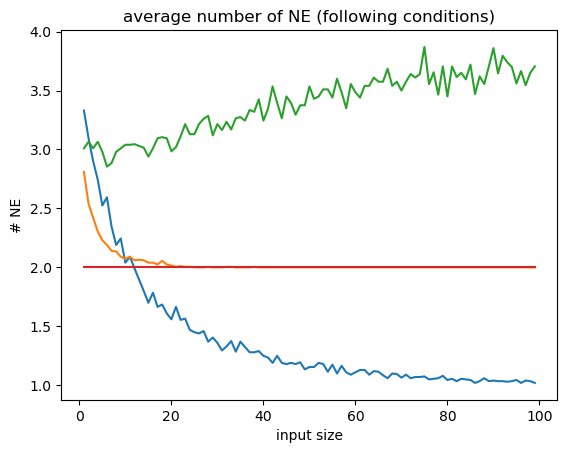

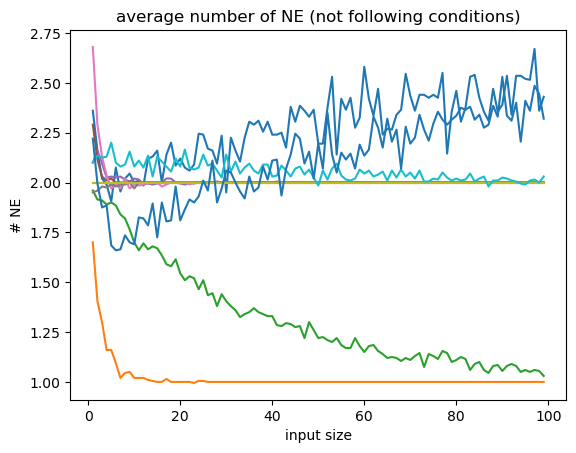

In [66]:
plot_curve("input size", "# NE", "average number of NE (following conditions)", steps, np.array(nums_NE)[conditions_true_NE].mean(2))
plot_curve("input size", "# NE", "average number of NE (not following conditions)", steps, np.array(nums_NE)[conditions_false_NE].mean(2))

In [67]:
# run params
num_steps = 100
repeats = 200

steps = np.array([x for x in range(1, num_steps)])

conditions_true_NE, conditions_false_NE = [], []
nums_NE = []

matrices = history_hybrid[:10]

for x in range(len(matrices)):
    nums_NE.append(study_num_NE(matrices[x], steps, repeats))

100%|██████████| 99/99 [00:07<00:00, 12.79it/s]


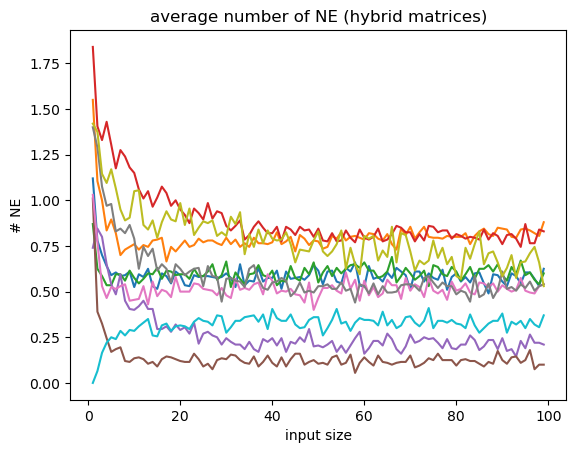

In [68]:
plot_curve("input size", "# NE", "average number of NE (hybrid matrices)", steps, np.array(nums_NE).mean(2))

# Complexity

### Utility functions

In [20]:
def eval_complexity(input_sizes, matrices, repeats, NE, times, fixed_input_size, fixed_n=False, fixed_m=False):
    for input_size in tqdm(input_sizes):
        c = counter(input_size)
        NE.append([])
        n_size = fixed_input_size if fixed_n else input_size 
        m_size = fixed_input_size if fixed_m else input_size 
        type_spaces_1, type_spaces_2, probas_1, probas_2 = generate_config_batch(repeats, n_size, m_size)
        for U in matrices:
            c.start_breakpoint()
            for rep in range(repeats):                
                res = NE_search(U, type_spaces_1[rep], type_spaces_2[rep], probas_1[rep], probas_2[rep])
                NE[-1].append(n_size if not res else res[4])
            c.stop_breakpoint()
        times.append(c.total_time)

def eval_complexity_dgpd(input_sizes, matrices, repeats, times, fixed_input_size, fixed_n=False, fixed_m=False):
    for input_size in tqdm(input_sizes):
        c = counter(input_size)
        n_size = fixed_input_size if fixed_n else input_size 
        m_size = fixed_input_size if fixed_m else input_size 
        type_spaces_1, type_spaces_2, probas_1, probas_2 = generate_config_batch(repeats, n_size, m_size)
        for U in matrices:
            c.start_breakpoint()
            for rep in range(repeats):
                res = NE_search_dgpd(U, type_spaces_1[rep], type_spaces_2[rep], probas_1[rep], probas_2[rep])
            c.stop_breakpoint()
        times.append(c.total_time)

### Complexity comparison

In [44]:
# run params
steps = 40
num_matrices = 100
repeats = 75

fixed_input_size = 10

input_sizes = np.array([5*x for x in range(1, steps)])
matrices = generate_matrix_batch(num_matrices)

times_n_m, times_n, times_m = [], [], []
NE_n_m, NE_n, NE_m = [], [], []
    
eval_complexity(input_sizes, matrices, repeats, NE_n_m, times_n_m, fixed_input_size)
eval_complexity(input_sizes, matrices, repeats, NE_n, times_n, fixed_input_size, fixed_m=True)
eval_complexity(input_sizes, matrices, repeats, NE_m, times_m, fixed_input_size, fixed_n=True)

100%|██████████| 39/39 [00:13<00:00,  2.83it/s]


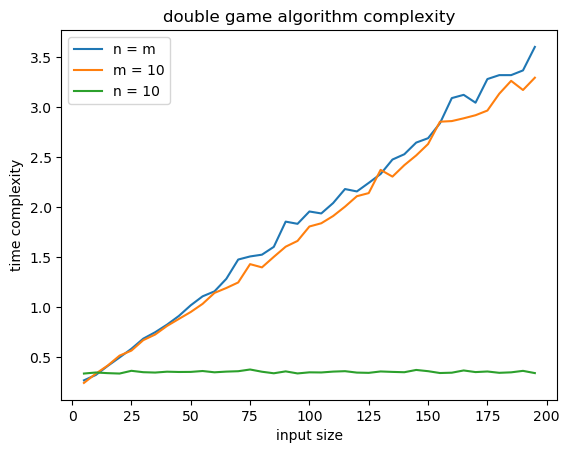

In [45]:
plot_curve(
    "input size",
    "time complexity",
    "double game algorithm complexity",
    input_sizes,
    [times_n_m, times_n, times_m],
    ['n = m', 'm = 10', 'n = 10']
)
# the main driver of the complexity is the length of the first type space
# minor improvement if the second type space has a fixed length 

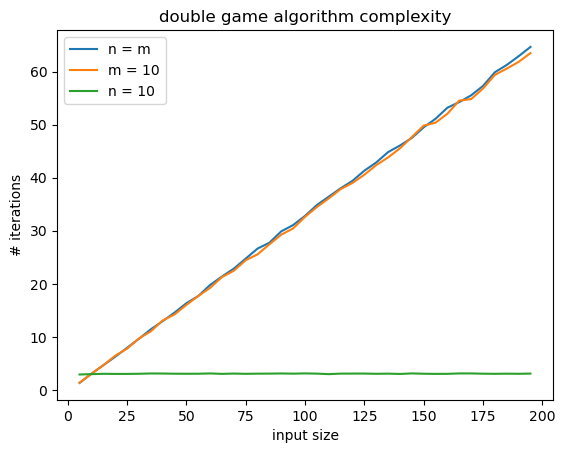

In [46]:
plot_curve(
    "input size", 
    "# iterations", 
    "double game algorithm complexity", 
    input_sizes,
    [np.array(NE_n_m).mean(1), np.array(NE_n).mean(1), np.array(NE_m).mean(1)], 
    ['n = m', 'm = 10', 'n = 10']
)
# we see that the number of iterations doesn't fully explain the complexity gap
# this gap is probably due to the increased cost of finder() when the second input size increases

In [47]:
matrices = [generate_dgpd_payoff() for _ in range(num_matrices)]

times_n_m_dgpd, times_n_dgpd, times_m_dgpd = [], [], []
    
eval_complexity_dgpd(input_sizes, matrices, repeats, times_n_m_dgpd, fixed_input_size)
eval_complexity_dgpd(input_sizes, matrices, repeats, times_n_dgpd, fixed_input_size, fixed_m=True)
eval_complexity_dgpd(input_sizes, matrices, repeats, times_m_dgpd, fixed_input_size, fixed_n=True)

100%|██████████| 39/39 [00:06<00:00,  5.87it/s]


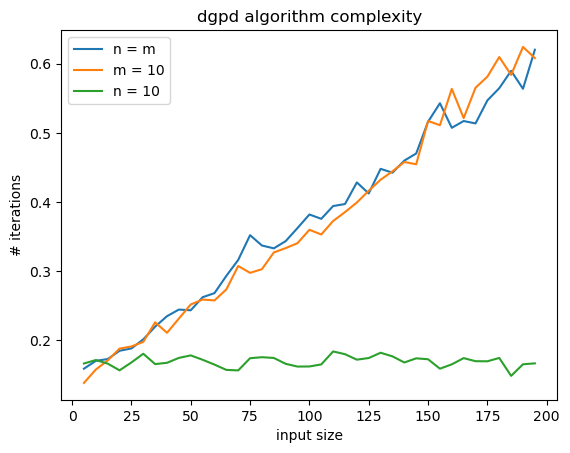

In [48]:
plot_curve(
    "input size",
    "# iterations",
    "dgpd algorithm complexity",
    input_sizes,
    [times_n_m_dgpd, times_n_dgpd, times_m_dgpd],
    ['n = m', 'm = 10', 'n = 10']
)
# the main driver of the complexity is the length of the first type space
# minor improvement if the second type space has a fixed length 

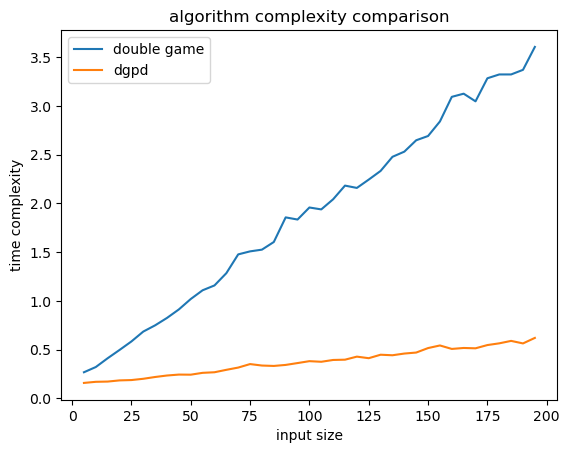

In [49]:
plot_curve(
    "input size",
    "time complexity",
    "algorithm complexity comparison",
    input_sizes,
    [times_n_m, times_n_m_dgpd],
    ['double game', 'dgpd']
)